<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/Anomaly%20Detection/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection


https://towardsdatascience.com/wondering-how-to-build-an-anomaly-detection-model-87d28e50309
https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-anomaly-detection-1233d23dba95

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
%matplotlib inline

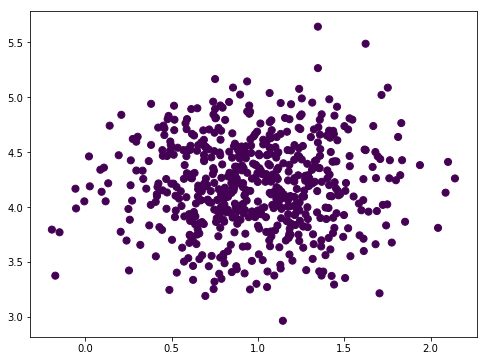

In [55]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=600, centers=1, cluster_std=0.4, random_state=3)

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
#plt.set_xlabel('X0')
#plt.set_ylabel('X1')
plt.show()

In [0]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var
  
  
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
 

In [0]:
p = multivariateGaussian(X, mu, sigma2)

In [52]:
print( "mu=", mu )
print( "mean", np.mean(X, axis=0))
print( "sigma", np.sqrt(sigma2) )
print( "std", np.std(X, axis=0))

mu= [0.97526953 4.1978901 ]
mean [0.97526953 4.1978901 ]
sigma [0.39238452 0.41386511]
std [0.39238452 0.41386511]


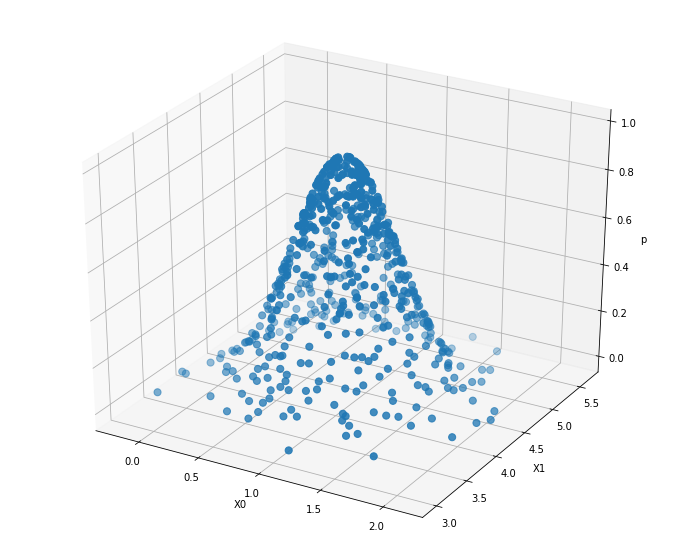

In [56]:
#Make a 3D plot

fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.grid(True)
ax.scatter3D(X[:, 0], X[:, 1], p, s=50, cmap='viridis')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('p')

plt.show()
  
